In [1]:
%run -i '../MARIOS/PyFiles/imports.py'
%run -i '../MARIOS/PyFiles/helpers.py'
%run -i "../MARIOS/PyFiles/experiment.py"

In [2]:
#TODO: Step 2: store hyper-parameter-results: Let's get some nice hyper-parameter plots.
#TODO: Step 1: check if observers are correct:
#TODO: fix


def check_shape_obs(file = "default"):
    if file == "default":
        nf = get_new_filename(exp = exp, current = True)
    else:
        nf = file
    with open(nf) as json_file: # 'non_exp_w.txt'
        datt = json.load(json_file)
    #datt = non_exp_best_args["dat"]
    #datt["obs_tr"], datt["obs_te"]   = np.array(datt["obs_tr"]), np.array(datt["obs_te"])
    #datt["resp_tr"], datt["resp_te"] = np.array(datt["resp_tr"]), np.array(datt["resp_te"])
    return(datt)

def load_data(file = "default", print_lst = ["nrmse"], bp = None):
    if bp != None:
        file = bp + file
    if file == "default":
        nf = get_new_filename(exp = exp, current = True)
    else:
        nf = file
    with open(nf) as json_file: # 'non_exp_w.txt'
        datt = json.load(json_file)
    for i in print_lst:
        print(datt[i])
    return(datt)



#experiment.save_json(exp = False)
#fp = bp + 'targetKhz:_0.01__obskHz:_0.01.txt'
#fp = bp + 'targetKhz:_0.02__obskHz:_0.01.txt'
def topline(spec_path, 
            base_path = "/Users/hayden/Desktop/experiment_results/2k/medium/",
            #base_path = #"./experiment_results/..."
            verbose = False,
            print_filestructure = False):
    
    print(base_path)
    fp = base_path + spec_path
    """
    targetKhz:_0.02__obskHz:_0.01.txt
    │   │   │   ├── targetKhz:_0.5__obskHz:_0.5.txt
    │   │   │   └── targetKhz:_0.5__obskHz:_1.0.txt
    """
    hi = load_data(file = fp)
    if print_filestructure == True:
        for i in hi.keys():
            print(i + "/")

            if type(hi[i]) == dict:

                for j in hi[i].keys():
                    print("    " +j)
    if verbose == True:
        print("DATA STRUCTURE: (it's a dict)")
        print("/n inputs:")
        print(hi["experiment_inputs"])
        print(hi["get_observer_inputs"])

        print("/n key saved values:")
        print(hi["best arguments"])
        print(hi["nrmse"])
    return(hi)

def recover_test_set(json_obj):
    """
    This function exists for an annoying reason: there is a shitty bug in my code.
    A timeline is dropped and surely this is minor if we can just recover the index by exact indices.
    """
    
    experiment_ = EchoStateExperiment(**json_obj["experiment_inputs"])
    
    obs_inputs = json_obj["get_observer_inputs"]
    obs_inputs["method"] = "exact"
    

    
    obs_idx, resp_idx = json_obj["obs_idx"], json_obj["resp_idx"]
    A_subset = experiment_.A.copy()
    
    # pred shape
    pred_shape = np.array(json_obj["prediction"]["interpolation"]); pred_shape = pred_shape.shape[0]                   
    
    A = experiment_.A
    
    train_len = (A.shape[0] - pred_shape)
    Train_Tmp, Test_Tmp  = A[:train_len,resp_idx], A[train_len:,resp_idx]
    
    
    
    print(Test_Tmp.shape)
    return(Train_Tmp, Test_Tmp)

#recover_test_set(hi)

In [3]:

def compare(truth, 
            unif_w_pred = None, 
            exp_w_pred = None, 
            ip_pred = None,
            columnwise = False,
            verbose = False):
    """
    This function provides two things, conditional on the columnwise variable.
    columnwise = False: cross-model comparison of nrmse
    
    columnwise = True: model nrmse correlary for each point.
    """
    #ip_res =    #runInterpolation(columnwise = columnwise)
    
    if type(unif_w_pred) != type(None):
        unif_nrmse = nrmse(pred_ = unif_w_pred, truth = truth, columnwise = columnwise)
        
    if type(exp_w_pred) != type(None):
        exp_nrmse = nrmse(pred_  = exp_w_pred , truth = truth, columnwise = columnwise)
    
    if type(ip_pred) != type(None):
        ip_nrmse = nrmse(pred_  = ip_pred , truth = truth, columnwise = columnwise)
        
    ip_res = {"nrmse" : ip_nrmse, "pred" : ip_pred}
        
    
    assert type(columnwise) == bool, "columnwise must be a boolean"
    
    if columnwise == False:
        if verbose != False:
            print("cubic spline interpolation nrmse: " + str(ip_res["nrmse"]))
            print("uniform weights rc nrmse: " + str(unif_nrmse))
            print("exponential weights rc nrmse: " + str(exp_nrmse))
            print("creating barplot")
        if type(exp_w_pred) != type(None):
            df = pd.DataFrame({"interpolation" : ip_res["nrmse"], 
                               "uniform rc" : unif_nrmse, 
                               "exponential rc" : exp_nrmse}, index = [0])
        else:
            df = pd.DataFrame({"interpolation" : ip_res["nrmse"], 
                               "uniform rc" : unif_nrmse}, index = [0])
        display(df)

        plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
        sns.catplot(data = df, kind = "bar")
        plt.title("model vs nrmse")
        plt.ylabel("nrmse")
        improvement = []
        for rc_nrmse in[unif_nrmse, exp_nrmse]:
            impr_spec = ((ip_res["nrmse"] - rc_nrmse)/ip_res["nrmse"]) * 100
            impr_spec = [round(impr_spec,1)]
            improvement += impr_spec

        pct_improve_unif, pct_improve_exp = improvement
        if pct_improve_unif > 0:
            print("unif improvement vs interpolation: nrmse " + str(-pct_improve_unif) + "%")
        else:
            print("rc didn't beat interpolation: nrmse +" + str(-pct_improve_unif) + "%")
        
        if pct_improve_exp > 0:
            print("exp improvement vs interpolation: nrmse " + str(-pct_improve_exp) + "%")
        else:
            print("rc didn't beat interpolation: nrmse +" + str(-pct_improve_exp) + "%")

        impr_rc_compare = round(((unif_nrmse - exp_nrmse)/unif_nrmse) * 100,1)

        if impr_rc_compare > 0:
            print("exp rc improvement vs unif rc: nrmse " + str(-impr_rc_compare) + "%")
        else:
            print("exp weights didn't improve rc: nrmse +" + str(-impr_rc_compare) + "%")
    else:
        print("creating first figure")
        model_names = ["interpolation", "uniform rc", "exponential rc"]
        for i, model_rmse_np in enumerate([ip_res["nrmse"], unif_nrmse, exp_nrmse]):
            model_rmse_pd = pd.melt(pd.DataFrame(model_rmse_np.T))
            model_rmse_pd.columns = ["t","y"]
            model_rmse_pd["model"] = model_names[i]
            if i == 0:
                models_pd = model_rmse_pd
            else:
                models_pd = pd.concat([models_pd, model_rmse_pd ], axis = 0)
        fig, ax = plt.subplots(1,1, figsize = (11, 6))
        sns.lineplot(x = "t", y = "y", hue = "model", data = models_pd, ax = ax)
        ax.set_title("model vs rmse")
        ax.set_ylabel("nrmse")
        ax.set_xlabel("Test idx")
        
def get_experiment(json_obj, verbose = False):
    
    experiment_ = EchoStateExperiment(**json_obj["experiment_inputs"])
    
    obs_inputs = json_obj["get_observer_inputs"]
    obs_inputs["method"] = "exact"
    
    experiment_.obs_idx, experiment_.resp_idx  = json_obj["obs_idx"], json_obj["resp_idx"]
    
    experiment_.get_observers(**obs_inputs, 
                              plot_split = True)
    if verbose == True:
        print("experiment inputs: " + str(json_obj["experiment_inputs"]))
        print("get_obs_inputs: " + str(obs_inputs))
        print("Train.shape: " + str(experiment_.Train.shape))
        print("Saved_prediction.shape: " + str(np.array(json_obj["prediction"]["uniform"]).shape))
        
        
    
        
    experiment_.already_trained(json_obj["best arguments"]["uniform"])
    print(experiment_.prediction.shape)
    print(experiment_.Test.shape)
    
    
    experiment_.Train, experiment_.Test = recover_test_set(json_obj)
    ### which line is missing?
    xx = range(experiment_.prediction.shape[0])
    
    
    #plt.imshow( experiment_.prediction)
    #plt.show()
    """
    #plt.imshow( experiment_.Test)
    #plt.show()
    
    sns.lineplot( x = xx, y = experiment_.prediction[ : , 0 ], label = "prediction from cluster 0 ")
    sns.lineplot( x = xx, y = experiment_.prediction[ : , 0 ], label = "prediction from cluster 1 ")
    sns.lineplot( x = xx, y = experiment_.Test[ : , 0 ], label = "actual data 0")
    sns.lineplot( x = xx, y = experiment_.Test[ : , -1 ], label = "actual data 1")
    #plt.plot(experiment_.Test[ : , 1 ])
    """
    
    #experiment_.plot_timeseries(method = "avg")
    
    if len(list(json_obj["prediction"].keys())) == 3:
        compare(
            truth       = np.array(experiment_.Test), 
            unif_w_pred = np.array(json_obj["prediction"]["uniform"]),
            ip_pred = np.array(json_obj["prediction"]["interpolation"]),
            exp_w_pred  = np.array(json_obj["prediction"]["exponential"]), 
            columnwise  = False,
            verbose = False)
    if len(list(json_obj["prediction"].keys())) == 2:
        compare(
            truth       = np.array(experiment_.Test), 
            unif_w_pred = np.array(json_obj["prediction"]["uniform"]),
            ip_pred = np.array(json_obj["prediction"]["interpolation"]),
            exp_w_pred  = None,#np.array(json_obj["prediction"]["exponential"]), 
            columnwise  = False,
            verbose = False)

    return(experiment_)
    
       
        #return(df)


# New experiments

{'interpolation': 0.04170350246985207, 'uniform': 0.003550118327331229}


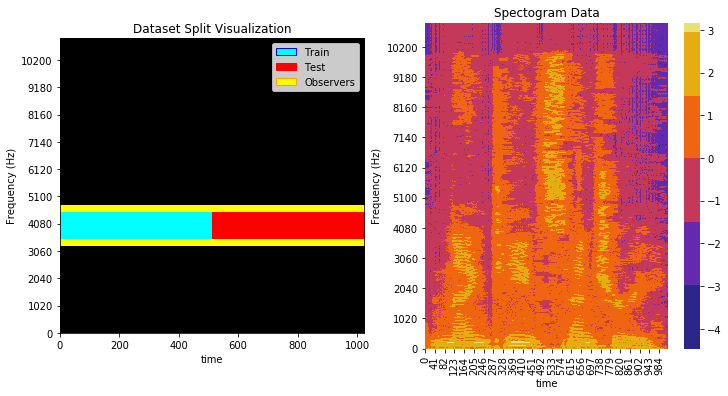

(512, 101)
(512, 52)
(512, 101)


,interpolation,uniform rc
0,0.041704,0.00355


UnboundLocalError: local variable 'exp_nrmse' referenced before assignment

<Figure size 640x480 with 0 Axes>

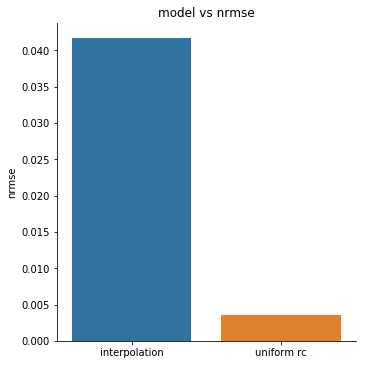

In [20]:

experiment_4 = load_data("./experiment_results/4k/medium/split_0.5/targetKhz:_1.0__obskHz:_0.5.txt")
experiment_4_obj = get_experiment(experiment_4)

experiment_1 = load_data('./experiment_results/2k/medium/split_0.5/targetKhz:_1.0__obskHz:_0.5.txt')
experiment_1_obj = get_experiment(experiment_1)

#/Users/hayden/Desktop/DL_LAB/Reservoir/MARIOS/experiment_results/2k/medium/split_0.5/targetKhz:_1.0__obskHz:_1.0.txt


experiment_2 = load_data('./experiment_results/2k/medium/split_0.5/targetKhz:_1.0__obskHz:_1.0.txt')
experiment_2_obj = get_experiment(experiment_2)

experiment_3 = load_data("./experiment_results/4k/medium/split_0.5/targetKhz:_0.5__obskHz:_1.0.txt")
experiment_3_obj = get_experiment(experiment_3)



experiment_5 = load_data("./experiment_results/4k/medium/split_0.5/targetKhz:_1.0__obskHz:_1.0.txt")
experiment_5_obj = get_experiment(experiment_5)

experiment_6 = load_data("./experiment_results/4k/medium/split_0.9/targetKhz:_0.5__obskHz:_0.5.txt")
experiment_6_obj = get_experiment(experiment_6)

experiment_7 = load_data("./experiment_results/4k/medium/split_0.9/targetKhz:_0.5__obskHz:_1.0.txt")
experiment_7_obj = get_experiment(experiment_7)

experiment_8 = load_data('./experiment_results/4k/medium/split_0.9/targetKhz:_1.0__obskHz:_0.5.txt')
experiment_8_obj = get_experiment(experiment_8)

experiment_9 = load_data('./experiment_results/4k/medium/split_0.9/targetKhz:_1.0__obskHz:_1.0.txt')
experiment_9_obj = get_experiment(experiment_9)

#experiment_10 = load_data('./experiment_results/4k/medium/split_0.5/targetKhz:_0.5__obskHz:_0.5.txt')
#experiment_10_obj = get_experiment(experiment_10)






[0, 1, 2, 3, 4, 5, 6, 7, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8]
[500.0, 1000.0, 1000.0, 500.0, 1000.0, 500.0, 1000.0, 500.0, 1000.0, 500.0, 1000.0, 1000.0, 500.0, 1000.0, 500.0, 1000.0, 500.0, 1000.0, 500.0, 1000.0, 1000.0, 500.0, 1000.0, 500.0, 1000.0, 500.0, 1000.0]
[1000.0, 1000.0, 500.0, 1000.0, 1000.0, 500.0, 500.0, 1000.0, 1000.0, 1000.0, 1000.0, 500.0, 1000.0, 1000.0, 500.0, 500.0, 1000.0, 1000.0, 1000.0, 1000.0, 500.0, 1000.0, 1000.0, 500.0, 500.0, 1000.0, 1000.0]


,experiment,model,nrmse,obs hz,target hz
0,0,interpolation,0.041935,500.0,1000.0
1,1,interpolation,0.042762,1000.0,1000.0
2,2,interpolation,0.025478,1000.0,500.0
3,3,interpolation,0.041704,500.0,1000.0
4,4,interpolation,0.041990,1000.0,1000.0
5,5,interpolation,0.028484,500.0,500.0
6,6,interpolation,0.029380,1000.0,500.0
7,7,interpolation,0.036205,500.0,1000.0
8,8,interpolation,0.037688,1000.0,1000.0
9,0,uniform,0.008971,500.0,1000.0


Text(0.5, 1.0, "Relavite NRMSE vs Interpolation model across different RC's")

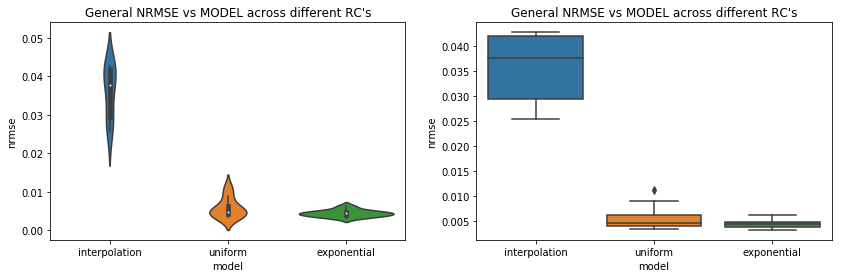

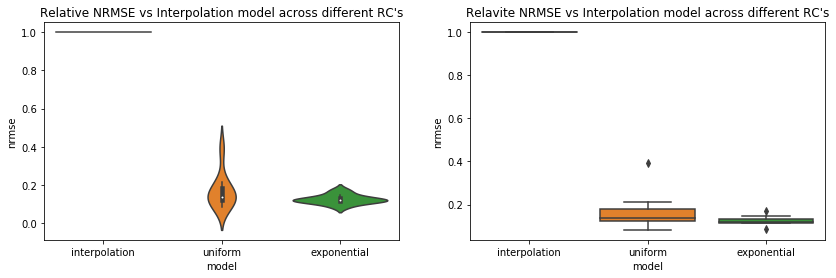

In [12]:
experiment_lst = [experiment_1, experiment_2, experiment_3, experiment_4, 
                  experiment_5, experiment_6, experiment_7, experiment_8, experiment_9]

def quick_dirty_convert(lst):
    lst *= 3
    print(lst)
    pd_ = pd.DataFrame(np.array(lst).reshape(-1,1))
    return(pd_)
    

idx_lst = list(range(len(experiment_lst)))
#idx_lst *= 3
#idx_lst = pd.DataFrame(np.array(idx_lst).reshape(-1,1))

idx_lst = quick_dirty_convert(idx_lst)

obs_hz_lst, targ_hz_lst = [], []

for i, experiment in enumerate(experiment_lst):
    targ_hz = experiment["experiment_inputs"]["target_hz"]
    obs_hz  = experiment["experiment_inputs"]["obs_hz"]
    
    
    if experiment["experiment_inputs"]["target_hz"] < 1:
        targ_hz *= 1000*1000
        obs_hz  *= 1000*1000
    obs_hz_lst  += [obs_hz]
    targ_hz_lst += [targ_hz]
    
        
    hz_line = {"target hz" : targ_hz }
    hz_line = Merge(hz_line , {"obs hz" : obs_hz })
    
    #print(hz_line)
    df_spec = experiment["nrmse"]
    #df_spec = Merge(experiment["nrmse"], {"target hz": targ_hz})
    df_spec = pd.DataFrame(df_spec, index = [0])
    
    
    
    df_spec_rel = df_spec.copy()
    df_spec_rel = df_spec_rel / experiment["nrmse"]["interpolation"]
    
    #print( df_spec_rel)
    #print(experiment["experiment_inputs"].keys())
    if i == 0:
        df = df_spec
        df_rel = df_spec_rel
        
    else:
        df = pd.concat([df, df_spec])
        df_rel = pd.concat([df_rel, df_spec_rel])

df_net = df_rel.copy()
        
obs_hz_lst, targ_hz_lst = quick_dirty_convert(obs_hz_lst), quick_dirty_convert(targ_hz_lst)
        
df, df_rel = pd.melt(df), pd.melt(df_rel)
df  = pd.concat( [idx_lst, df,  obs_hz_lst, targ_hz_lst] ,axis = 1)

df_rel = pd.concat( [idx_lst, df_rel,  obs_hz_lst, targ_hz_lst], axis = 1)

df.columns     = ["experiment", "model", "nrmse", "obs hz", "target hz" ]
df_rel.columns = ["experiment", "model", "nrmse", "obs hz", "target hz"] 
display(df)



fig, ax = plt.subplots(1, 2, figsize = (14,4))
sns.violinplot( y = "nrmse" , x = "model", data = df, ax = ax[0])
sns.boxplot( y = "nrmse" , x = "model", data = df, ax = ax[1])
ax[0].set_title("General NRMSE vs MODEL across different RC's")
ax[1].set_title("General NRMSE vs MODEL across different RC's")


fig, ax = plt.subplots(1, 2, figsize = (14,4))
sns.violinplot( y = "nrmse" , x = "model", data = df_rel, ax = ax[0])
sns.boxplot( y = "nrmse" , x = "model", data = df_rel, ax = ax[1])
ax[0].set_title("Relative NRMSE vs Interpolation model across different RC's")
ax[1].set_title("Relavite NRMSE vs Interpolation model across different RC's")


Text(0.5, 1.0, "Relavite NRMSE vs Interpolation model across different RC's")

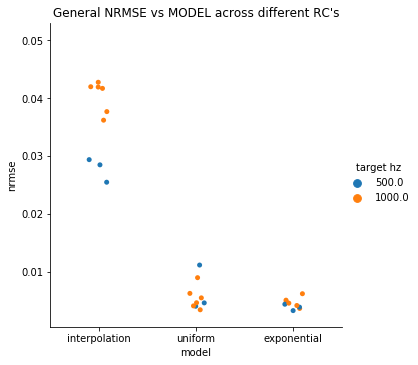

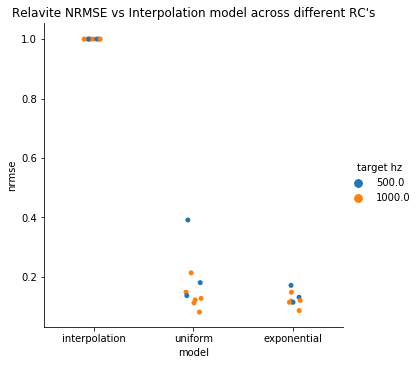

In [13]:
sns.catplot(y = "nrmse" , x = "model", hue ="target hz", data = df)
plt.title("General NRMSE vs MODEL across different RC's")
sns.catplot(y = "nrmse" , x = "model", hue ="target hz", data = df_rel)
plt.title("Relavite NRMSE vs Interpolation model across different RC's")

# Old experiments

/Users/hayden/Desktop/experiment_results/2k/medium/
{'interpolation': 0.0395523911947735, 'uniform': 0.008455659375210041, 'exponential': 0.008443754314894253}


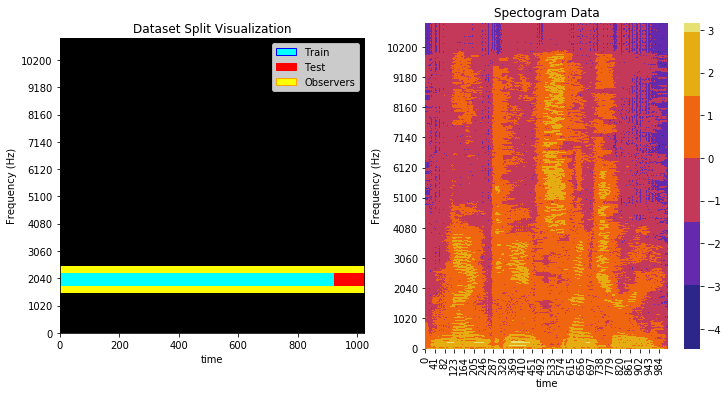

(103, 51)
(103, 52)
(103, 51)


,interpolation,uniform rc,exponential rc
0,0.039552,0.008456,0.008444


unif improvement vs interpolation: nrmse -78.6%
exp improvement vs interpolation: nrmse -78.7%
exp rc improvement vs unif rc: nrmse -0.1%
/Users/hayden/Desktop/experiment_results/2k/medium/
{'interpolation': 0.03909516122428118, 'uniform': 0.013463952460055623, 'exponential': 0.009400709001748447}


<Figure size 640x480 with 0 Axes>

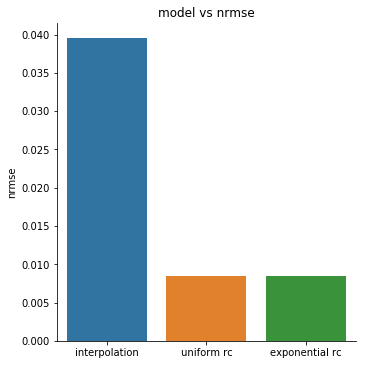

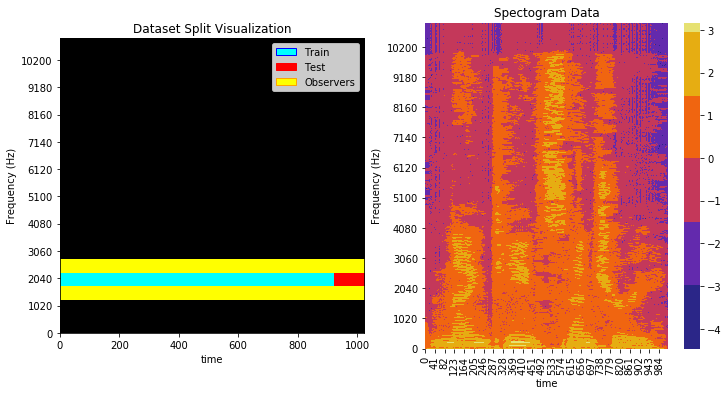

(103, 51)
(103, 102)
(103, 51)


,interpolation,uniform rc,exponential rc
0,0.039095,0.013464,0.009401


unif improvement vs interpolation: nrmse -65.6%
exp improvement vs interpolation: nrmse -76.0%
exp rc improvement vs unif rc: nrmse -30.2%


NameError: name 'merge_unif_exp' is not defined

<Figure size 640x480 with 0 Axes>

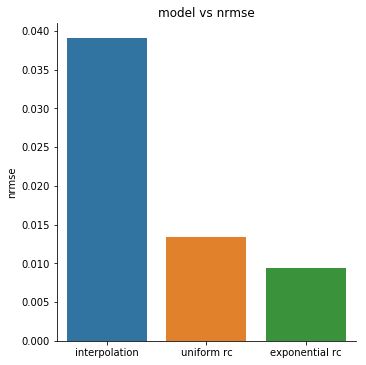

In [5]:
experiment_1 = topline("split_0.9/targetKhz:_0.5__obskHz:_0.5.txt", print_filestructure = False)
#hh = load_data()
#print(loadA.shape)
experiment_1_obj = get_experiment(experiment_1)


experiment_2 = topline("split_0.9/targetKhz:_0.5__obskHz:_1.0.txt") 
experiment_2_obj = get_experiment(experiment_2)

fp_exp1 =  '/Users/hayden/Desktop/experiment_results copy/2k/medium/split_0.5/fix_0.5_1.0/exp_targetKhz:_0.5__obskHz:_1.0.txt'
fp_unif1 = '/Users/hayden/Desktop/experiment_results copy/2k/medium/split_0.5/fix_0.5_1.0/targetKhz:_0.5__obskHz:_1.0.txt'
experiment_3 =  merge_unif_exp(fp_unif = fp_unif1, fp_exp = fp_exp1)   
experiment_3_obj = get_experiment(experiment_3)


#0.5split_0.5_0.5
fp_unif1 =  '/Users/hayden/Desktop/experiment_results copy/2k/medium/split_0.5/fix_0.5_0.5/unif_targetKhz:_0.5__obskHz:_0.5.txt'
fp_exp1 = '/Users/hayden/Desktop/experiment_results copy/2k/medium/split_0.5/fix_0.5_0.5/targetKhz:_0.5__obskHz:_0.5.txt'
experiment_4 =  merge_unif_exp(fp_unif = fp_unif1, fp_exp = fp_exp1)   
experiment_4_obj = get_experiment(experiment_4)

experiment_5 = load_data('experiment_results/2k/medium/split_0.5/targetKhz:_1.0__obskHz:_0.5.txt',
                         bp = '/Users/hayden/Desktop/')
experiment_5_obj = get_experiment(experiment_5)

experiment_6 = load_data('experiment_results/2k/medium/split_0.5/targetKhz:_1.0__obskHz:_1.0.txt',
                        bp = '/Users/hayden/Desktop/')
experiment_6_obj = get_experiment(experiment_6)

experiment_7 = load_data('experiment_results/4k/medium/split_0.5/targetKhz:_0.5__obskHz:_1.0.txt',
                         bp = '/Users/hayden/Desktop/')
experiment_7_obj = get_experiment(experiment_7)

experiment_8 = load_data('experiment_results/4k/medium/split_0.5/targetKhz:_1.0__obskHz:_0.5.txt',
                        bp = '/Users/hayden/Desktop/')
experiment_8_obj = get_experiment(experiment_8)

In [11]:
for i, experiment in enumerate(experiment_lst):
    #print(experiment['get_observer_inputs'].keys())
    split = experiment['get_observer_inputs']["split"]
    targ_hz = experiment['experiment_inputs']["target_hz"]
    targ_idx_LB, targ_idx_UB = experiment["resp_idx"][0], experiment["resp_idx"][-1]
    obs_hz = experiment['experiment_inputs']["obs_hz"]
    f = np.array(experiment_8_obj.f)
    obs_idx = experiment["obs_idx"] 

    obs_idx  = [int(j) for j in experiment["obs_idx"] ]
    obs_freq = [max(f) - f[j] for j in obs_idx]
    
    
    print("\nexperiment: " + str(i) + ", target hz: " + str(targ_hz) + ", obs hz: " + str(obs_hz) +
         ", split: " + str(split))

    
    print("target idx: [" + str(targ_idx_LB) + ", " + str(targ_idx_UB) + "]")
    print("target freq: [" + str(max(f) - f[targ_idx_LB]) + ", " + str(max(f) - f[targ_idx_UB]) + "]")
    print("obs idx: " + str(obs_idx))
    print("obs freq: " + str(obs_freq))
    print(experiment_8_obj.A.shape[0] - np.array(experiment["prediction"]["interpolation"]).shape[0])
    print(experiment_8_obj.A.shape[0])
    #print(experiment["resp_idx"])

NameError: name 'experiment_lst' is not defined

In [ ]:
def show_exp_weights(json_obj, llambda = None):
    print(json_obj.keys())
    esn_ = EchoStateNetwork(**json_obj["best arguments"]["exponential"], plot = True)
    esn_.obs_idx  = json_obj["obs_idx"]
    esn_.resp_idx = json_obj["resp_idx"]
    if llambda != None:
        esn_.llambda = llambda
    esn_.get_exp_weights()


for i in experiment_lst:
    show_exp_weights(i)  
#show_exp_weights(experiment_2)  



In [ ]:
show_exp_weights(i, llambda = 10**-3) 

In [ ]:
10**-2 
np.log(10**-4)/np.log(10)


In [ ]:
experiment_lst = [experiment_1, experiment_2, experiment_3, experiment_4, 
                  experiment_5, experiment_6, experiment_7, experiment_8]

def quick_dirty_convert(lst):
    lst *= 3
    print(lst)
    pd_ = pd.DataFrame(np.array(lst).reshape(-1,1))
    return(pd_)
    

idx_lst = list(range(len(experiment_lst)))
#idx_lst *= 3
#idx_lst = pd.DataFrame(np.array(idx_lst).reshape(-1,1))

idx_lst = quick_dirty_convert(idx_lst)

obs_hz_lst, targ_hz_lst = [], []

for i, experiment in enumerate(experiment_lst):
    targ_hz = experiment["experiment_inputs"]["target_hz"]
    obs_hz  = experiment["experiment_inputs"]["obs_hz"]
    
    
    if experiment["experiment_inputs"]["target_hz"] < 1:
        targ_hz *= 1000*1000
        obs_hz  *= 1000*1000
    obs_hz_lst  += [obs_hz]
    targ_hz_lst += [targ_hz]
    
        
    hz_line = {"target hz" : targ_hz }
    hz_line = Merge(hz_line , {"obs hz" : obs_hz })
    
    #print(hz_line)
    df_spec = experiment["nrmse"]
    #df_spec = Merge(experiment["nrmse"], {"target hz": targ_hz})
    df_spec = pd.DataFrame(df_spec, index = [0])
    
    df_spec_rel = df_spec.copy()
    df_spec_rel = df_spec_rel / experiment["nrmse"]["interpolation"]
    
    #print( df_spec_rel)
    #print(experiment["experiment_inputs"].keys())
    if i == 0:
        df = df_spec
        df_rel = df_spec_rel
        
    else:
        df = pd.concat([df, df_spec])
        df_rel = pd.concat([df_rel, df_spec_rel])

#obs_hz_lst  *= 3
#targ_hz_lst *= 3

obs_hz_lst, targ_hz_lst = quick_dirty_convert(obs_hz_lst), quick_dirty_convert(targ_hz_lst)
        
df, df_rel = pd.melt(df), pd.melt(df_rel)
df  = pd.concat( [idx_lst, df,  obs_hz_lst, targ_hz_lst] ,axis = 1)

df_rel = pd.concat( [idx_lst, df_rel,  obs_hz_lst, targ_hz_lst], axis = 1)

df.columns     = ["experiment", "model", "nrmse", "obs hz", "target hz" ]
df_rel.columns = ["experiment", "model", "nrmse", "obs hz", "target hz"] 
display(df)



fig, ax = plt.subplots(1, 2, figsize = (14,4))
sns.violinplot( y = "nrmse" , x = "model", data = df, ax = ax[0])
sns.boxplot( y = "nrmse" , x = "model", data = df, ax = ax[1])
ax[0].set_title("General NRMSE vs MODEL across different RC's")
ax[1].set_title("General NRMSE vs MODEL across different RC's")


fig, ax = plt.subplots(1, 2, figsize = (14,4))
sns.violinplot( y = "nrmse" , x = "model", data = df_rel, ax = ax[0])
sns.boxplot( y = "nrmse" , x = "model", data = df_rel, ax = ax[1])
ax[0].set_title("Relative NRMSE vs Interpolation model across different RC's")
ax[1].set_title("Relavite NRMSE vs Interpolation model across different RC's")


In [ ]:
sns.catplot(y = "nrmse" , x = "model", hue ="target hz", data = df)
plt.title("General NRMSE vs MODEL across different RC's")
sns.catplot(y = "nrmse" , x = "model", hue ="target hz", data = df_rel)
plt.title("Relavite NRMSE vs Interpolation model across different RC's")

In [ ]:
sns.catplot(y = "nrmse" , x = "model", hue ="obs hz", data = df)
plt.title("General NRMSE vs MODEL across different RC's")
sns.catplot(y = "nrmse" , x = "model", hue ="obs hz", data = df_rel)
plt.title("Relavite NRMSE vs Interpolation model across different RC's")

In [ ]:
hi = topline("split_0.9/targetKhz:_1.0__obskHz:_1.0.txt")  #GOOD!
get_experiment(hi)

In [ ]:
hi = topline("split_0.9/targetKhz:_1.0__obskHz:_0.5.txt")  #GOOD!
get_experiment(hi)

In [ ]:
hi = load_data("experiment_results/2k/medium/split_0.5/targetKhz:_0.5__obskHz:_1.0.txt")#topline("split_0.5/targetKhz:_0.5__obskHz:_1.0.txt")  #GOOD!
get_experiment(hi)

In [ ]:
hi = topline("split_0.5/targetKhz:_0.5__obskHz:_0.5.txt")  #GOOD!
#get_experiment(hi)
get_experiment(hi)

In [ ]:


def merge_unif_exp(fp_unif, fp_exp):
    exp_dat = load_data(fp_exp)
    unif_dat = load_data(fp_unif)
    assert exp_dat["prediction"]["interpolation"] == unif_dat["prediction"]["interpolation"], "something is wrong!"
    joint_dat = unif_dat.copy()
    for i in ["prediction", "nrmse", "best arguments"]:
        exp_dict = {"exponential" : exp_dat[i]["exponential"]}
        joint_dat[i] = Merge(joint_dat[i], exp_dict)
    print(joint_dat["best arguments"])
        
     
    return(joint_dat)
#0.5_1.0


In [ ]:
def hyper_parameter_plot(experiment_lst):
    for i, experiment in enumerate(experiment_lst):
        df_spec_unif = pd.DataFrame(experiment["best arguments"]["uniform"], index = [0])
        df_spec_exp  = pd.DataFrame(experiment["best arguments"]["exponential"], index = [0])
        if i == 0:
            df_unif = df_spec_unif
        else:
            df_unif = pd.concat([df_unif, df_spec_unif])
        if i == 0:
            df_exp = df_spec_exp
        else:
            df_exp = pd.concat([df_exp, df_spec_exp])
    print("uniform")
    display(df_unif)
    print("exp")
    display(df_exp)
    

In [ ]:
experiment_lst =[experiment_1, experiment_2, experiment_3, experiment_4,
                 experiment_5, experiment_6, experiment_7, experiment_8
                ]

In [ ]:
hyper_parameter_plot(experiment_lst)

In [ ]:
hi = load_data('experiment_results/4k/medium/split_0.9/targetKhz:_1.0__obskHz:_1.0.txt')
get_experiment(hi) # broken

In [ ]:
experiment_5 = load_data('/Users/hayden/Desktop/DL_LAB/Reservoir/MARIOS/experiment_results/4k/medium/split_0.5/targetKhz:_1.0__obskHz:_0.5.txt')
                         #bp = '/Users/hayden/Desktop/')
experiment_5_obj = get_experiment(experiment_5)